In [3]:
import pandas as pd
import numpy as np
import math 
from datetime import datetime

import matplotlib.pyplot as plt  
import seaborn as sns

In [9]:
# Import the data data
subscriptions = pd.read_csv('subscriptionsdataFINAL.csv') 
visitation_part1 = pd.read_csv('visitationdataPART1.csv') 
visitation_part2 = pd.read_csv('visitationdataPART2.csv')  

In [10]:
# Chane the timestamp
subscriptions['Join Date'] =  pd.to_datetime(subscriptions['Join Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions['Join_year'] = pd.DatetimeIndex(subscriptions['Join Date']).year
subscriptions['End Date'] =  pd.to_datetime(subscriptions['End Date'].str.upper(), format='%b-%y', yearfirst=False)
subscriptions.dropna()
subscriptions.head()

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015


In [418]:
# Add the peak/off-peak data to the subscriptions data
subscriptions_1 = subscriptions.copy()
visitation_part1_peakvisit = visitation_part1.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_part2_peakvisit = visitation_part2.groupby(['CustomerID', 'peakvisits']).size().unstack(fill_value=0)
visitation_peakvisit = pd.merge(visitation_part1_peakvisit,visitation_part2_peakvisit,on='CustomerID',how='outer').sort_index().replace({np.nan:0})
visitation_peakvisit['False'] = visitation_peakvisit['False_x'] + visitation_peakvisit['False_y']
visitation_peakvisit['True'] = visitation_peakvisit['True_x'] + visitation_peakvisit['True_y']
visitation_peakvisit=visitation_peakvisit.drop(columns=['False_x','True_x','False_y','True_y'])
visitation_peakvisit['Peak_proportion'] = visitation_peakvisit['True']/(visitation_peakvisit['True'] + visitation_peakvisit['False'])
def classify_peak(Peak_proportion):
    if Peak_proportion < 0.25:
        return 'Off_Peak_Customer'
    elif 0.25 <= Peak_proportion < 0.75:
        return 'Average'
    else:
        return 'Peak_Customer'
visitation_peakvisit['Peak_category'] = visitation_peakvisit['Peak_proportion'].apply(lambda x : classify_peak(x))
subscriptions_1 = pd.merge(subscriptions_1,visitation_peakvisit['Peak_category'],on='CustomerID',how='outer')
subscriptions_1

,Club,Join Date,Affluence,Gender,Subscription Type,End Date,CustomerID,BirthYear,Join_year,Peak_category
0,Enfield,2011-12-01,C1,Male,Standard,2011-12-01,1,1992,2011,Average
1,Greenwich,2018-06-01,A,Female,Standard,NaT,2,1972,2018,Average
2,Islington,2018-03-01,B,Female,Standard,2018-10-01,3,1985,2018,Average
3,Hounslow,2015-10-01,C1,Female,Standard,2015-12-01,4,1972,2015,Average
4,Barnet,2015-05-01,C2,Male,Standard,2015-12-01,5,1982,2015,Average
...,...,...,...,...,...,...,...,...,...,...
850028,Lewisham,2018-12-01,A,Male,Standard,NaT,850029,1995,2018,Average
850029,Tower Hamlets,2013-10-01,B,Male,Standard,2014-02-01,850030,1987,2013,Average
850030,Redbridge,2018-05-01,C1,Female,Standard,2018-09-01,850031,1985,2018,Average
850031,Camden,2017-07-01,B,Female,Standard,2017-09-01,850032,1978,2017,Average


In [419]:
# Monthly
# Calculate the number of member joined, the number of member left, net member, cumulative member
subscriptions_2 = subscriptions_1.copy()
member_joined_data = subscriptions_2.groupby(['Join Date','Peak_category']).size().reset_index(name='Number_of_Member_Joined')
member_joined_data = member_joined_data.rename(columns={'Join Date': "Date"})
member_left_data = subscriptions_2.groupby(['End Date','Peak_category']).size().reset_index(name='Number_of_Member_Left')
member_left_data=member_left_data.rename(columns={'End Date': "Date"})
member_left_data['Date']=member_left_data['Date'] + pd.DateOffset(months=1)
member_data = pd.merge(member_joined_data,member_left_data,on = ['Peak_category','Date'],how='outer').sort_index().replace({np.nan:0})
member_data['Net_Member'] = member_data['Number_of_Member_Joined'] - member_data['Number_of_Member_Left'] 
member_data = pd.DataFrame(member_data.groupby(['Date','Peak_category']).sum())
member_data['Cumulative_Member'] = member_data.groupby(level=-1)['Net_Member'].cumsum()
member_data

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Peak_category                                                       
2009-05-01 Average                              666.0                    0.0   
           Off_Peak_Customer                     10.0                    0.0   
           Peak_Customer                         16.0                    0.0   
2009-06-01 Average                              540.0                   30.0   
           Off_Peak_Customer                      3.0                    3.0   
...                                               ...                    ...   
2018-12-01 Off_Peak_Customer                    312.0                  138.0   
           Peak_Customer                        609.0                  279.0   
2019-01-01 Average                                0.0                12032.0   
           Off_Peak_Customer                      0.0                  149.0   
           Peak_Customer                          0.0                  287.0   

                              Net_Member  Cumulative_Member  
Date       Peak_category                                     
2009-05-01 Average                 666.0              666.0  
           Off_Peak_Customer        10.0               10.0  
           Peak_Customer            16.0               16.0  
2009-06-01 Average                 510.0             1176.0  
           Off_Peak_Customer         0.0               10.0  
...                                  ...                ...  
2018-12-01 Off_Peak_Customer       174.0              656.0  
           Peak_Customer           330.0             1216.0  
2019-01-01 Average              -12032.0            50908.0  
           Off_Peak_Customer      -149.0              507.0  
           Peak_Customer          -287.0              929.0  

[351 rows x 4 columns]

In [420]:
# Monthly
# Calculate the revenue
member_data_1 = member_data.copy()
date_while_price_changed = pd.Timestamp('2016-01-01') 
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
dates_before_price_change = pd.date_range(date_min, date_while_price_changed, freq = 'MS')
dates_after_price_change = pd.date_range(date_while_price_changed, date_max, freq = 'MS')

Average_data = pd.DataFrame(member_data_1.xs('Average', level=1, drop_level=False))
Off_Peak_Customer_data = pd.DataFrame(member_data_1.xs('Off_Peak_Customer', level=1, drop_level=False))
Peak_Customer_data = pd.DataFrame(member_data_1.xs('Peak_Customer', level=1, drop_level=False))

Average_data.loc[dates_before_price_change,'Membership_Revenue'] = Average_data.loc[dates_before_price_change,'Cumulative_Member'] * 25.99
Average_data.loc[dates_after_price_change,'Membership_Revenue'] = Average_data.loc[dates_after_price_change,'Cumulative_Member'] * 30.99
Off_Peak_Customer_data.loc[dates_before_price_change,'Membership_Revenue'] = Off_Peak_Customer_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
Off_Peak_Customer_data.loc[dates_after_price_change,'Membership_Revenue'] = Off_Peak_Customer_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99
Peak_Customer_data.loc[dates_before_price_change,'Membership_Revenue'] = Peak_Customer_data.loc[dates_before_price_change,'Cumulative_Member'] * 20.99
Peak_Customer_data.loc[dates_after_price_change,'Membership_Revenue'] = Peak_Customer_data.loc[dates_after_price_change,'Cumulative_Member'] * 26.99

Average_data = Average_data['Membership_Revenue']
Off_Peak_Customer_data = Off_Peak_Customer_data['Membership_Revenue']
Peak_Customer_data = Peak_Customer_data['Membership_Revenue']

Revenue_data = pd.DataFrame(pd.concat([Average_data, Off_Peak_Customer_data,Peak_Customer_data]))

member_data_1 = pd.merge(member_data_1,Revenue_data,on = ['Date','Peak_category'],how='left')
member_data_1['Join_Revenue'] = member_data_1['Number_of_Member_Joined'] * 5
member_data_1['Total_Revenue'] = member_data_1['Membership_Revenue'] +  member_data_1['Join_Revenue']
member_data_1

Number_of_Member_Joined  Number_of_Member_Left  \
Date       Peak_category                                                       
2009-05-01 Average                              666.0                    0.0   
           Off_Peak_Customer                     10.0                    0.0   
           Peak_Customer                         16.0                    0.0   
2009-06-01 Average                              540.0                   30.0   
           Off_Peak_Customer                      3.0                    3.0   
...                                               ...                    ...   
2018-12-01 Off_Peak_Customer                    312.0                  138.0   
           Peak_Customer                        609.0                  279.0   
2019-01-01 Average                                0.0                12032.0   
           Off_Peak_Customer                      0.0                  149.0   
           Peak_Customer                          0.0                  287.0   

                              Net_Member  Cumulative_Member  \
Date       Peak_category                                      
2009-05-01 Average                 666.0              666.0   
           Off_Peak_Customer        10.0               10.0   
           Peak_Customer            16.0               16.0   
2009-06-01 Average                 510.0             1176.0   
           Off_Peak_Customer         0.0               10.0   
...                                  ...                ...   
2018-12-01 Off_Peak_Customer       174.0              656.0   
           Peak_Customer           330.0             1216.0   
2019-01-01 Average              -12032.0            50908.0   
           Off_Peak_Customer      -149.0              507.0   
           Peak_Customer          -287.0              929.0   

                              Membership_Revenue  Join_Revenue  Total_Revenue  
Date       Peak_category                                                       
2009-05-01 Average                      17309.34        3330.0       20639.34  
           Off_Peak_Customer              209.90          50.0         259.90  
           Peak_Customer                  335.84          80.0         415.84  
2009-06-01 Average                      30564.24        2700.0       33264.24  
           Off_Peak_Customer              209.90          15.0         224.90  
...                                          ...           ...            ...  
2018-12-01 Off_Peak_Customer            17705.44        1560.0       19265.44  
           Peak_Customer                32819.84        3045.0       35864.84  
2019-01-01 Average                    1577638.92           0.0     1577638.92  
           Off_Peak_Customer            13683.93           0.0       13683.93  
           Peak_Customer                25073.71           0.0       25073.71  

[351 rows x 7 columns]

In [421]:
# Yearly
# The number of members and the total revenue
member_data_yearly=member_data_1.reset_index()
member_data_yearly['Year'] = member_data_yearly.apply(lambda row: row['Date'].year,axis=1)
member_data_yearly=member_data_yearly.groupby(['Year','Peak_category']).sum()
member_data_yearly.head()

Number_of_Member_Joined  Number_of_Member_Left  \
Year Peak_category                                                       
2009 Average                             8648.0                 2724.0   
     Off_Peak_Customer                    116.0                   67.0   
     Peak_Customer                        221.0                  126.0   
2010 Average                            22174.0                17512.0   
     Off_Peak_Customer                    300.0                  269.0   

                        Net_Member  Cumulative_Member  Membership_Revenue  \
Year Peak_category                                                          
2009 Average                5924.0            26431.0           686941.69   
     Off_Peak_Customer        49.0              226.0             4743.74   
     Peak_Customer            95.0              428.0             8983.72   
2010 Average                4662.0           101816.0          2646197.84   
     Off_Peak_Customer        31.0              801.0            16812.99   

                        Join_Revenue  Total_Revenue  
Year Peak_category                                   
2009 Average                 43240.0      730181.69  
     Off_Peak_Customer         580.0        5323.74  
     Peak_Customer            1105.0       10088.72  
2010 Average                110870.0     2757067.84  
     Off_Peak_Customer        1500.0       18312.99

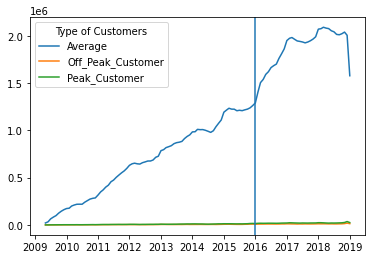

In [422]:
#Plot the chart of monthly revenue
member_data_3=member_data_1.copy()
date_min = pd.Timestamp('2009-05-01') 
date_max = pd.Timestamp('2019-01-01') 
Date = pd.date_range(date_min, date_max, freq = 'MS')

Average_data = pd.DataFrame(member_data_3.xs('Average', level=1, drop_level=False))
Off_Peak_Customer_data = pd.DataFrame(member_data_3.xs('Off_Peak_Customer', level=1, drop_level=False))
Peak_Customer_data = pd.DataFrame(member_data_3.xs('Peak_Customer', level=1, drop_level=False))

Average = Average_data['Total_Revenue']
Off_Peak_Customer = Off_Peak_Customer_data['Total_Revenue']
Peak_Customer = Peak_Customer_data['Total_Revenue']

plt.plot(Date,Average,label='Average')
plt.plot(Date,Off_Peak_Customer,label='Off_Peak_Customer')
plt.plot(Date,Peak_Customer,label='Peak_Customer')

plt.legend(title='Type of Customers')
plt.axvline(x='2016-01-01')

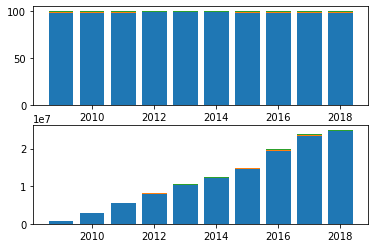

In [423]:
# Plot the Percent stacked barplot and barplot of yearly revenue,seperating the Peak_category
r =  np.arange(2009,2019)

Average_data = pd.DataFrame(member_data_yearly.xs('Average', level=1, drop_level=False)).drop([2019])
Off_Peak_Customer_data = pd.DataFrame(member_data_yearly.xs('Off_Peak_Customer', level=1, drop_level=False)).drop([2019])
Peak_Customer_data = pd.DataFrame(member_data_yearly.xs('Peak_Customer', level=1, drop_level=False)).drop([2019])

Average_Revenue = Average_data['Total_Revenue']
Off_Peak_Customer_Revenue = Off_Peak_Customer_data['Total_Revenue']
Peak_Customer_Revenue = Peak_Customer_data['Total_Revenue']

totals = [i+j+k for i,j,k in zip(Average_Revenue, Off_Peak_Customer_Revenue,Peak_Customer_Revenue)]

Average_revenue_stacked = [i / j * 100 for i,j in zip(Average_Revenue, totals)]
Off_Peak_Customer_revenue_stacked = [i / j * 100 for i,j in zip(Off_Peak_Customer_Revenue, totals)] 
Peak_Customer_revenue_stacked = [i / j * 100 for i,j in zip(Peak_Customer_Revenue, totals)] 

plt.subplot(2, 1, 1)
plt.bar(r,Average_revenue_stacked)
plt.bar(r,Off_Peak_Customer_revenue_stacked, bottom=Average_revenue_stacked)
plt.bar(r,Peak_Customer_revenue_stacked, bottom=[i+j for i,j in zip(Average_revenue_stacked, Off_Peak_Customer_revenue_stacked)])

plt.subplot(2, 1, 2)
plt.bar(r,Average_Revenue)
plt.bar(r,Off_Peak_Customer_Revenue, bottom=Average_Revenue)
plt.bar(r,Peak_Customer_Revenue, bottom=[i+j for i,j in zip(Average_Revenue, Off_Peak_Customer_Revenue)])

plt.show()

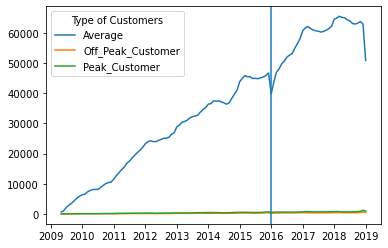

In [424]:
# Plot the cumulative members monthly
Dates = pd.date_range(min(Date), max(Date), freq = 'MS')
Average = member_data_1.xs('Average', level=1, drop_level=False)['Cumulative_Member']
Off_Peak_Customer = member_data_1.xs('Off_Peak_Customer', level=1, drop_level=False)['Cumulative_Member']
Peak_Customer = member_data_1.xs('Peak_Customer', level=1, drop_level=False)['Cumulative_Member']
plt.plot(Dates,Average,label='Average')
plt.plot(Dates,Off_Peak_Customer,label='Off_Peak_Customer')
plt.plot(Dates,Peak_Customer,label='Peak_Customer')
plt.legend(title='Type of Customers')
plt.axvline(x='2016-01-01')

In [425]:
# Breakdown by club and type of customer
number_of_member_breakdown_by_club = subscriptions_1.groupby(['Club','Peak_category','Join_year']).size().reset_index(name='Number_of_Member')
number_of_member_breakdown_by_club

,Club,Peak_category,Join_year,Number_of_Member
0,Barking,Average,2016,4936
1,Barking,Average,2017,5656
2,Barking,Average,2018,5330
3,Barking,Off_Peak_Customer,2016,52
4,Barking,Off_Peak_Customer,2017,61
...,...,...,...,...
553,Westminster,Peak_Customer,2014,91
554,Westminster,Peak_Customer,2015,85
555,Westminster,Peak_Customer,2016,75
556,Westminster,Peak_Customer,2017,82


In [426]:
# Functions which calculate the difference between peak customer and off-peak customer given the year
def calculate_number_of_member_breakdown_by_club(year):
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club.loc[number_of_member_breakdown_by_club['Join_year'] == year]
    sum_number_of_member_breakdown_by_club_year = number_of_member_breakdown_by_club_year.groupby(['Club']).sum(['Number_of_Member']).drop(columns=['Join_year'])
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club_year.merge(sum_number_of_member_breakdown_by_club_year, how='left', on='Club')
    number_of_member_breakdown_by_club_year['Peak_category_percentage'] = number_of_member_breakdown_by_club_year['Number_of_Member_x'] / number_of_member_breakdown_by_club_year['Number_of_Member_y']
    number_of_member_breakdown_by_club_year=number_of_member_breakdown_by_club_year.drop(columns=['Number_of_Member_x','Number_of_Member_y','Join_year'])
    return number_of_member_breakdown_by_club_year

def calculate_difference_peak_offpeak_year(year):
    x=calculate_number_of_member_breakdown_by_club(year)
    df = pd.DataFrame(index = list(x['Club'].unique()))
    for club in list(x['Club'].unique()):
        peak_percentage = list(x.loc[(x['Club'] == club) & (x['Peak_category'] == 'Peak_Customer')]['Peak_category_percentage'])[0]
        offpeak_percentage = list(x.loc[(x['Club'] == club) & (x['Peak_category'] == 'Off_Peak_Customer')]['Peak_category_percentage'])[0]
        Difference = peak_percentage-offpeak_percentage
        df.loc[club,['difference_between_peak_and_offpeak']] = Difference
    return df

In [427]:
# Calculate the difference betweekn peak and off peak for all clubs over 10 years, and filter all the clubs that have opened less than 4 years
index_2=list(np.arange(2009,2019))
index_1=list(number_of_member_breakdown_by_club['Club'].unique())
iterables = [index_1,index_2]
index=pd.MultiIndex.from_product(iterables, names=["Club", "Year"])
zeros_list = np.zeros(len(index_2)*len(index_1))
s = pd.DataFrame(data = zeros_list,index=index,columns=['difference_between_peak_and_offpeak'])
for year in index_2:
     df = calculate_difference_peak_offpeak_year(year)
     for club in list(df.index):
        s.loc[(club, year)]['difference_between_peak_and_offpeak'] = df.loc[club]['difference_between_peak_and_offpeak']  
difference_between_peak_and_offpeak = s[s.difference_between_peak_and_offpeak != 0]   

for club in list(difference_between_peak_and_offpeak.index.get_level_values(0).unique()):
    number_of_row = difference_between_peak_and_offpeak.loc[club].shape[0]
    if number_of_row <4:
        difference_between_peak_and_offpeak = difference_between_peak_and_offpeak.drop(club) 
difference_between_peak_and_offpeak.head(8)

difference_between_peak_and_offpeak
Club   Year                                     
Barnet 2011                             0.007311
       2012                             0.010499
       2013                             0.008633
       2014                             0.013087
       2015                             0.007184
       2016                             0.011745
       2017                             0.006720
       2018                             0.015520

In [428]:
# Find the percentage change between peak and offpeak for all clubs
club_list = list(difference_between_peak_and_offpeak.index.get_level_values(0).unique())
for club in club_list:
    df = difference_between_peak_and_offpeak.loc[club]
    years = sorted(list(df.index.get_level_values(0)[-3:]), reverse=True)
    for year in years:
        this_year = year
        last_year = year-1
        this_year_diff = df.loc[this_year]['difference_between_peak_and_offpeak'] 
        last_year_diff = df.loc[last_year]['difference_between_peak_and_offpeak']
        growth_rate = (this_year_diff-last_year_diff) / last_year_diff
        difference_between_peak_and_offpeak.loc[(club,this_year)]['difference_between_peak_and_offpeak'] = growth_rate
    years = set(sorted(list(df.index.get_level_values(0)[-3:]), reverse=True))
    years_all = set(sorted(list(df.index.get_level_values(0)), reverse=True))
    years_delete = list(set(years_all)-set(years))
    for year in years_delete:
        difference_between_peak_and_offpeak=difference_between_peak_and_offpeak.drop([(club,year)])
        
difference_between_peak_and_offpeak.head(8)

difference_between_peak_and_offpeak
Club   Year                                     
Barnet 2016                             0.634968
       2017                            -0.427828
       2018                             1.309412
Bexley 2016                            -0.189020
       2017                             0.060401
       2018                            -0.103272
Brent  2016                             0.261929
       2017                            -0.300892

In [431]:
club_list = list(difference_between_peak_and_offpeak.index.get_level_values(0).unique())
for club in club_list:
    df = difference_between_peak_and_offpeak.loc[club]
    if (df['difference_between_peak_and_offpeak'] < 0).all():
        print(club,'Customer are coming to peak time')
    if (df['difference_between_peak_and_offpeak'] > 0).all():
        print(club,'Customer are coming to offpeak time')

Greenwich Customer are coming to offpeak time
Southwark Customer are coming to offpeak time
